# Setup

## Easy Install

In [8]:
#Install list of libraries
# %pip install imbalanced-learn
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn
# %pip install scipy
# %pip install seaborn --upgrade
# %pip install graphviz
# %pip install xgboost
# %pip install lightgbm
# %pip install catboost

## Imports and Variables

In [9]:
from os import path, getcwd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline 
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.feature_selection import VarianceThreshold, chi2, f_classif, SelectKBest, SelectFromModel
from scipy.stats import kendalltau
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, matthews_corrcoef, confusion_matrix

# Tree Visualisation
from sklearn.tree import export_graphviz
# from IPython.display import Image
import graphviz

subjects = [102, 104, 105, 107, 110, 111, 115, 116, 117, 118, 120, 126, 127, 130, 131, 132, 133, 135, 138, 141, 143, 144]
col = ['1','2','3','Label', 'Frontal P3 mean', 'Frontal P3 STD', 'Posterior P3 mean', 'Posterior P3 STD', 'Frontal alpha mean', 
           'Posterior alpha mean', 'Alpha variability', 'Reaction time Mean', 'Reaction time variability', 'Accuracy', 'Frontal P3 log energy entropy', 
           'Frontal P3 Shannon entropy', 'Frontal P3 SURE entropy', 'Frontal P3 Skewness', 'Frontal P3 Kurtosis', 'Frontal alpha log energy entropy',
           'Frontal alpha Shannon entropy', 'Frontal alpha SURE entropy', 'Frontal alpha Skewness', 'Frontal alpha Kurtosis', 
           'Posterior P3 log energy entropy', 'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
           'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
           'Posterior alpha Kurtosis'
]
cwd = getcwd()
target_names = ['Task Unrelated Thought', 'Task Related Thought']
results_file = 'Results.xlsx'


## Data Collection

In [10]:
#Load all subject mat files, append TR and TUR structures to dataframe
for a in subjects:
    file = 'Feature_data_'+str(a)+'.mat'
    #Absolute path to mat file:
    #loc = os.path.join('C:/Users/pisis/OneDrive - University of Calgary/2024/AIRS/TR and TUT data',file)
    loc = path.join(cwd, 'TR and TUT data', file)
    subData = loadmat(loc)['data']
    subData_TR = subData['TR'][0,0]
    subData_TUR = subData['TUR'][0,0]
    subDF_TR = pd.DataFrame(subData_TR, columns = col)
    subDF_TUR = pd.DataFrame(subData_TUR, columns = col)
    if a==subjects[0]:
        totalDF = pd.concat([subDF_TR,subDF_TUR])
    else:
        totalDF = pd.concat([totalDF, subDF_TR])
        totalDF = pd.concat([totalDF, subDF_TUR])

#Show Data with NaN values:
# print(totalDF[totalDF.isnull().any(axis=1)])
# NOTE: Subject 109 has NaN values in the Reaction time Mean and Reaction time variability columns. Excluded from analysis.
# totalDF.fillna(0, inplace=True)

totalDF.reset_index(drop=True, inplace=True)
# print(totalDF)


In [11]:
Y = totalDF.Label
Y = Y - 1
all_features = totalDF.iloc[:, 4:]

## Feature Selection
Feature selection is for determining the most important features in our data. We compared all features, the alpha + posterior features, and finally, the alpha + posterior + behavioural features before using the built-in feature analysis (suggested by Sarah).  
[There are many types of feature selection techniques](https://youtu.be/LTE7YbRexl8?si=xW9kJt1lciKEKwAW). 
1. Filter-based techniques:
    - Correlation
    - Variance threshold
    - Chi squared
    - Anova
    - Information Gain
2. Wrapper techniques:
    - Recursive Feature Elimination (RFE)
3. Embed techniques
    - L1 & L2
    - Pruning/Decision trees

In [12]:
ap_columns = ['Posterior P3 mean', 'Posterior P3 STD', 'Posterior alpha mean', 'Alpha variability', 'Accuracy', 'Posterior P3 log energy entropy', 
              'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
              'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
              'Posterior alpha Kurtosis']
ap_features = totalDF[ap_columns]

apb_columns = ['Posterior P3 mean', 'Posterior P3 STD', 'Posterior alpha mean', 'Alpha variability', 'Reaction time Mean', 'Reaction time variability', 'Accuracy',
               'Posterior P3 log energy entropy', 'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
               'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
               'Posterior alpha Kurtosis']
apb_features = totalDF[apb_columns]

### Correlation Matrix Feature Selection

In [13]:
# Correlation Matrix:
corrMat = all_features.corr()
plt.figure(figsize=(20,20))
# sns.heatmap(corrMat, annot=True, cmap='Blues', fmt=".2f")

# All features with correlation ge than .80:
columns_to_drop = ['Frontal P3 log energy entropy','Frontal alpha log energy entropy', 'Frontal alpha Kurtosis', 
                   'Posterior P3 log energy entropy', 'Posterior alpha log energy entropy', 'Posterior alpha Kurtosis']
uncorr_features = all_features.drop(columns=columns_to_drop, axis=1)
# sns.heatmap(uncorr_features.corr(), annot=True, cmap='Blues', fmt=".2f")

<Figure size 2000x2000 with 0 Axes>

### Kendall's Tau Correlation Matrix

In [14]:
kenmat = all_features.corr(method='kendall')
# sns.heatmap(kenmat, annot=True, cmap='Blues', fmt=".2f")

# All features with kendall correlation greater than .80
columns_to_drop = ['Frontal P3 log energy entropy', 'Posterior P3 log energy entropy']
kendall_features = all_features.drop(columns=columns_to_drop, axis=1)

### Variance Threshold

In [15]:
vt = VarianceThreshold(threshold=0.1)
vt.fit(all_features)
mask = vt.get_support()
print("Features excluded: ", all_features.columns[~mask].values)
vt_features = all_features.loc[:, mask]

Features excluded:  ['Accuracy' 'Frontal P3 Kurtosis' 'Frontal alpha Skewness'
 'Posterior P3 Skewness' 'Posterior P3 Kurtosis']


### SelectKBest - ANOVA

In [16]:
test = SelectKBest(score_func=f_classif, k=30)
fit = test.fit(all_features, Y)
mask = fit.get_support()
print("Features excluded: ", all_features.columns[~mask].values)
anova_features = all_features.loc[:, mask]

Features excluded:  []


### Final Feature Selection
This is the "switch" box if you want to test out a different mode of feature selection:

In [17]:
# 'AP' = alpha + posterior, 'APB' = alpha + posterior + behvaioural, 'all' = all features
Select_features = 'uncorr'
Notes = ''

if Select_features == 'AP':
    X = ap_features
elif Select_features == 'APB':
    X = apb_features
elif Select_features == 'uncorr':
    X = uncorr_features
elif Select_features == 'vt':
    X = vt_features
elif Select_features == 'ANOVA':
    X = anova_features
elif Select_features == 'kendalls':
    X = kendall_features
else: 
    X = all_features
    


# print(X.columns)
# Verify that Labels contain only 0 and 1:
# print(X.Label.unique())

## Normalizer Switch

In [18]:
normalized = 3
if normalized == 1:
    scaler = StandardScaler()
elif normalized == 2:
    scaler = MinMaxScaler()
elif normalized == 3:
    scaler = Normalizer()
else:
    scaler = None

# Model Selection and Parameter Tuning

## Variables init
Choose what type of KFold, which measures you would like, what info you would like to store in results. Some resources:
- [svm](https://www.youtube.com/watch?v=efR1C6CvhmE)
- [Gradient Boosting info](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/)

In [19]:
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# results = {'Timestamp': [], 'Features': Select_features, 'CrossVal': type(kf).__name__, 'model': [], "Accuracy": [], "BA": [], "Matt_Corr_Coef": [], 'AUC': [], 'CnfM00': [], 'CnfM01': [], 
#            'CnfM10': [], 'CnfM11': [], 'Notes': Notes}
# Fill this with the models you would like to test:
# regressors = [LogisticRegression(max_iter=1800, random_state=42), RandomForestClassifier(random_state=42), GradientBoostingClassifier(random_state=42), SVC(random_state=42), KNeighborsClassifier(), 
            #   XGBClassifier(random_state=42), LGBMClassifier(random_state=42), CatBoostClassifier(random_state=42)]
# regressors = [CatBoostClassifier(depth= 6, iterations= 300, learning_rate= 0.1, random_state=42), 
#               RandomForestClassifier(bootstrap= False, max_depth= 40, max_features= "log2", min_samples_leaf= 1, 
#                                      min_samples_split= 2, n_estimators= 200, random_state=42)]
# regressors = [RandomForestClassifier(bootstrap= False, max_depth= 40, max_features= "log2", min_samples_leaf= 1, 
#                                      min_samples_split= 2, n_estimators= 200, random_state=42)]
# Define the metrics
param_results = {}
scoring = {
    'accuracy': metrics.make_scorer(accuracy_score),
    'balanced_accuracy': metrics.make_scorer(balanced_accuracy_score),
    'matthews_corrcoef': metrics.make_scorer(matthews_corrcoef),
    'AUC': metrics.make_scorer(roc_auc_score),
    'tp': metrics.make_scorer(tp),
    'fp': metrics.make_scorer(fp),
    'tn': metrics.make_scorer(tn),
    'fn': metrics.make_scorer(fn),
}
models = [
    ('RandomForest', RandomForestClassifier(), 
     {
         'classifier__n_estimators': [100, 200, 300], 
         'classifier__max_depth': [20, 30, 40], 
         'classifier__min_samples_split': [2, 5, 10], 
         'classifier__min_samples_leaf': [1, 2, 4], 
         'classifier__bootstrap': [True, False]
         }
     ),
    ('CatBoost', CatBoostClassifier(), 
     {
         'classifier__depth': [4, 6, 10], 
         'classifier__iterations': [100, 200, 300], 
         'classifier__learning_rate': [0.01, 0.1, 0.5]
         }
     ),
    ('LightGBM', LGBMClassifier(), 
     {
         'classifier__n_estimators': [100, 200, 300], 
         'classifier__max_depth': [10, 20, 30, 40], 
         'classifier__learning_rate': [0.01, 0.1, 0.5]
         }
     ),
]

__Within-fold processing__:
Preprocessing and feature selection should be done within the cross-validation loop to avoid data leakage or overfitting. 
1. StratifiedKFold.split - split the data into n folds: n-1 training folds and 1 test fold. Run n times with n different test folds. Stratified means the classification ratios in each fold are similar to the ratio in the original dataset. 
2. SMOTE - increase the number of samples in the minority group synthetically
3. Normalization/Standardization - Scale the data, usually to values between 0 and 1. Prevents certain models from adding more weight to larger gaps or higher numbers. 

In [20]:
best_params = []
best_models = []
best_scores = []

for name, model, param_grid in models:
    pipe = Pipeline([('smote', SMOTE(random_state=42)), ('normalizer', scaler), ('classifier', model)])
    
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, refit='balanced_accuracy', cv=inner_cv, n_jobs=-1)
    
    grid_search.fit(X, Y)
    print(f"Best model: {grid_search.best_estimator_['classifier']}")
    print(f"Best hyperparameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")
    best_params.append(grid_search.best_params_)
    best_models.append(grid_search.best_estimator_['classifier'])
    best_scores.append(grid_search.best_score_)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    param_results[name] = cv_results
    
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    nested_score = cross_validate(grid_search, X, Y, scoring=scoring, cv=outer_cv, n_jobs=-1)
    
    print(f"Model: {name}")
    print(f"Accuracy: {nested_score['test_accuracy'].mean()}")
    print(f"Balanced Accuracy: {nested_score['test_balanced_accuracy'].mean()}")
    print(f"Matthews Correlation Coefficient: {nested_score['test_matthews_corrcoef'].mean()}")
    print(f"AUC: {nested_score['test_AUC'].mean()}")
    print(f"Confusion Matrix: \n[[{nested_score['test_tp'].sum()}, {nested_score['test_fp'].sum()}], \n [{nested_score['test_fn'].sum()}, {nested_score['test_tn'].sum()}]]")
    
    
    

Best model: Pipeline(steps=[('smote', SMOTE(random_state=42)), ('normalizer', Normalizer()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2))])
Best hyperparameters: {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Model: RandomForest
Accuracy: 0.6608695652173913
Balanced Accuracy: 0.5226535947712418
Matthews Correlation Coefficient: 0.04721779048499013
AUC: 0.5226535947712418
Confusion Matrix: 
[[42, 136], 
 [97, 412]]
0:	learn: 0.6842993	total: 138ms	remaining: 27.5s
1:	learn: 0.6723965	total: 143ms	remaining: 14.1s
2:	learn: 0.6627887	total: 147ms	remaining: 9.63s
3:	learn: 0.6486765	total: 151ms	remaining: 7.39s
4:	learn: 0.6377742	total: 155ms	remaining: 6.04s
5:	learn: 0.6261245	total: 159ms	remaining: 5.13s
6:	learn: 0.6164882	total: 162ms	remaining: 4.48s
7:	learn: 0.6087960	total: 167ms	remaining: 4.02s
8:	

## Record Results
Add these Results and Test Conditions to Results.xlsx. Will delete duplicate results within conditions.

In [21]:
# results['Normalized'] = normalized
# df_newScores = pd.DataFrame(results)
# print(df_newScores)
# df_existingRecord = pd.read_excel(results_file)
# df_combined = pd.concat([df_existingRecord, df_newScores], ignore_index=True)
# df_combined.drop_duplicates(subset=['Features', 'model', "Accuracy", "BA", "Matt_Corr_Coef", 'AUC', 'CnfM00', 'CnfM01', 'CnfM10', 'CnfM11', 'Notes'], keep='last', inplace = True)
# df_combined.sort_values(by='Matt_Corr_Coef', ascending=False, inplace=True)
# df_combined.to_excel(results_file, index=False)

In [30]:
print(param_results['RandomForest'].columns.values)

['mean_fit_time' 'std_fit_time' 'mean_score_time' 'std_score_time'
 'param_classifier__bootstrap' 'param_classifier__max_depth'
 'param_classifier__min_samples_leaf'
 'param_classifier__min_samples_split' 'param_classifier__n_estimators'
 'params' 'split0_test_accuracy' 'split1_test_accuracy'
 'split2_test_accuracy' 'split3_test_accuracy' 'split4_test_accuracy'
 'split5_test_accuracy' 'split6_test_accuracy' 'split7_test_accuracy'
 'split8_test_accuracy' 'split9_test_accuracy' 'mean_test_accuracy'
 'std_test_accuracy' 'rank_test_accuracy' 'split0_test_balanced_accuracy'
 'split1_test_balanced_accuracy' 'split2_test_balanced_accuracy'
 'split3_test_balanced_accuracy' 'split4_test_balanced_accuracy'
 'split5_test_balanced_accuracy' 'split6_test_balanced_accuracy'
 'split7_test_balanced_accuracy' 'split8_test_balanced_accuracy'
 'split9_test_balanced_accuracy' 'mean_test_balanced_accuracy'
 'std_test_balanced_accuracy' 'rank_test_balanced_accuracy'
 'split0_test_matthews_corrcoef' 'split1_

For the presentation. Once model is decided, can use the following to generate graphs showing parameters vs performance.

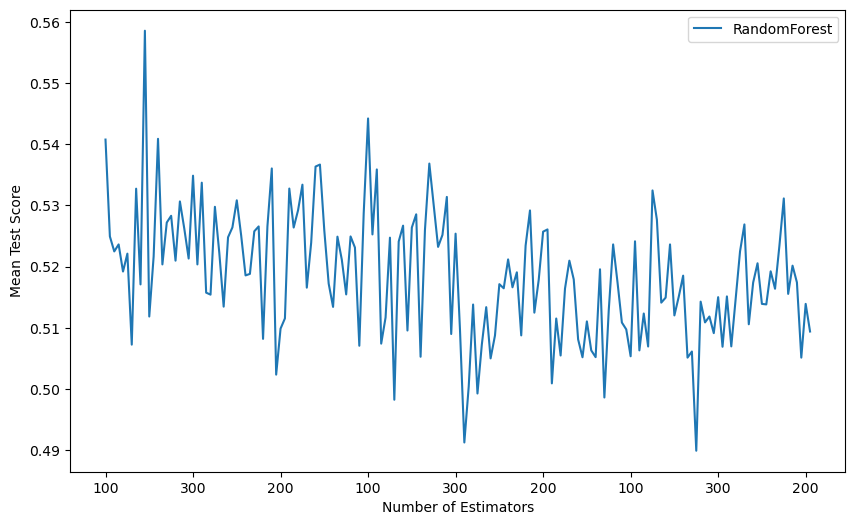

In [31]:
plt.figure(figsize=(10, 6))
param_results['RandomForest'].plot('param_classifier__n_estimators', 'mean_test_balanced_accuracy', label='RandomForest', ax=plt.gca())
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()